In [3]:
%config Completer.use_jedi = False

In [47]:
from sklearn.impute import KNNImputer
from rich.console import Console
from rich.pretty import Pretty
import pandas as pd
import typer

console = Console()

In [48]:
def printRange(something):
    console = Console()
    if len(something) > 100:
        console.print(Pretty(something[:100]))
        console.print(f"...and {len(something)-100} more elements.")
    else:
        console.print(Pretty(something))

Función que automaticamente intenta darle un rango de variables a atributos que no sean numeric

In [49]:
from torch import float64


def setUniqueNumberic(df, column, unique_values):
    if len(unique_values) == 2:
        df[column] = df[column].apply(lambda x: 0 if x == unique_values[0] else 1)
    else:
        df[column] = df[column].apply(lambda x: unique_values.tolist().index(x))

def testNumericAttributes(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            unique_values = df[column].unique()
            console.print(f"Column: {column} - Unique values: ")
            printRange(unique_values)
            if typer.confirm(f"Convert {column} to numeric?"):
                conversion_type = typer.prompt("\n-> Choose method: (u)nique or (s)tring)")
                if conversion_type == 'u':
                    setUniqueNumberic(df, column, unique_values)
                elif conversion_type == 's':
                    df[column] = pd.to_numeric(df[column], errors='coerce').astype('Float64')
                else:
                    console.print("Invalid conversion type. Please choose 'unique' or 'string.'\n")
            else:
                console.print("Column conversion cancelled.\n=")



In [ ]:
df = pd.read_csv('../datos_homeloan.csv')
testNumericAttributes(df)

Imputador que coge como base k=3, le da peso a la distancia de los atributos

In [104]:
imputer = KNNImputer(n_neighbors=5, weights="distance", metric="nan_euclidean")
imputer.fit(df)
df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)

In [105]:
print(df_imputed)

     Loan_ID  Gender  Married  Dependents  Education  SelfEmployed  \
0        0.0     0.0      0.0         0.0        0.0           0.0   
1        1.0     0.0      1.0         1.0        0.0           0.0   
2        2.0     0.0      1.0         0.0        0.0           1.0   
3        3.0     0.0      1.0         0.0        1.0           0.0   
4        4.0     0.0      0.0         0.0        0.0           0.0   
..       ...     ...      ...         ...        ...           ...   
609    609.0     1.0      0.0         0.0        0.0           0.0   
610    610.0     0.0      1.0         3.0        0.0           0.0   
611    611.0     0.0      1.0         1.0        0.0           0.0   
612    612.0     0.0      1.0         2.0        0.0           0.0   
613    613.0     1.0      0.0         0.0        0.0           1.0   

     ApplicantIncome  CoapplicantIncome  LoanAmount  LoanAmountTerm  \
0             5849.0                0.0  143.937757           360.0   
1             458

Se intentará ahora, con los datos medio preparados usar la integración para saber que variables estan correlacionadas

In [90]:
import seaborn as sns

In [106]:
df_imputed.drop('Loan_ID', axis=1, inplace=True)
df_imputed.drop('Gender', axis=1, inplace=True)

In [107]:
corr_matrix = df_imputed.corr(numeric_only = True)

In [102]:
print(corr_matrix)

                    Married  Dependents  Education  SelfEmployed  \
Married            1.000000    0.338689   0.006759     -0.038153   
Dependents         0.338689    1.000000   0.060466      0.005622   
Education          0.006759    0.060466   1.000000     -0.021130   
SelfEmployed      -0.038153    0.005622  -0.021130      1.000000   
ApplicantIncome    0.052119    0.103416  -0.140760      0.095664   
CoapplicantIncome  0.069725    0.010322  -0.062175      0.052308   
LoanAmount         0.151353    0.126253  -0.177797      0.086863   
LoanAmountTerm    -0.091535   -0.067915  -0.080551     -0.039015   
PropertyArea       0.006411   -0.010566  -0.003592     -0.012231   
LoanStatus        -0.096657    0.007318   0.085884     -0.010880   

                   ApplicantIncome  CoapplicantIncome  LoanAmount  \
Married                   0.052119           0.069725    0.151353   
Dependents                0.103416           0.010322    0.126253   
Education                -0.140760          

# Gráfica de correlación

<AxesSubplot: >

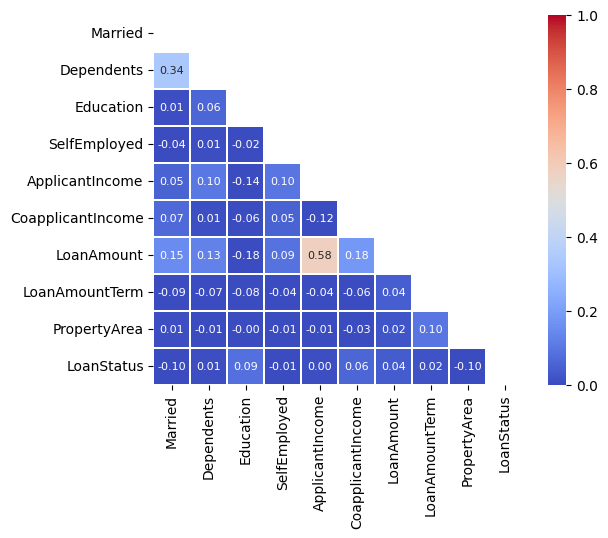

In [108]:
import numpy as np
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, square=True, linewidths=0.2, annot_kws={'size': 8}, fmt='.2f', vmin=0, vmax=1)